# 1 RNN

# 1 RNN(LSTM)을 사용한 텍스트 분류

## 1) 공통

In [1]:
import os
import random
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from tqdm.auto import tqdm

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.show()

## 2)  IMDB 데이터셋 (긍정/부정) 다운로드

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
imdb_dir = '/content/drive/MyDrive/IMDB_Dataset.csv'

In [15]:
pd.read_csv(imdb_dir)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [16]:
df = pd.read_csv(imdb_dir)
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## 3) 학습데이터 준비

다음은 문장을 전처리하여 숫자화하고 padding을 추가하여 문자열을 encoding하고,
 이를 dataset, dataloader로 만들어 학습을 위한 `batch`로 만들어준다.

In [20]:
tokenized=[]

stopwords = [l.rstrip() for l in open('./drive/MyDrive/stopwords.txt', 'r').readlines()]
import re
for sentence in df['review']:
    sentence = re.sub('<br />', ' ', sentence)
    sentence = re.sub('[^\w\s\'\"\&]+', '', sentence)
    temp = sentence.lower().split(' ') # 토큰화
    temp = [word for word in temp if not word in stopwords] # 불용어 제거
    tokenized.append(list(filter(None, temp)))
print(tokenized[:10])

[['one', 'reviewers', 'mentioned', 'watching', '1', 'oz', 'episode', "you'll", 'hooked', 'right', 'exactly', 'happened', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'manyaryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'moreso', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', "wouldn't", 'dare', 'forget', 'pretty', 'pictures', 'painted', 'mainstream', 'a

In [21]:
from nltk import FreqDist
vocab = FreqDist(np.hstack(tokenized))

In [22]:
len(vocab)

205069

In [23]:
vocab_size = 8190 # +2개는 PAD, UNK
vocab = vocab.most_common(vocab_size)

word_to_index = {word[0] : index + 2 for index, word in enumerate(vocab)}
word_to_index['<PAD>'] = 1
word_to_index['<UNK>'] = 0

In [24]:
encoded = []
for line in tokenized: #입력 데이터에서 1줄씩 문장을 읽음
    temp = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      try:
        temp.append(word_to_index[w]) # 글자를 해당되는 정수로 변환
      except KeyError: # 단어 집합에 없는 단어일 경우 UNK로 대체된다.
        temp.append(word_to_index['<UNK>']) # UNK의 인덱스로 변환

    encoded.append(temp)

print(encoded[:10])

[[4, 1922, 931, 56, 373, 3751, 282, 358, 2984, 107, 479, 469, 21, 58, 3073, 3751, 5234, 0, 51, 465, 183, 107, 559, 54, 1576, 43, 8058, 5493, 0, 43, 2360, 5802, 5212, 1347, 283, 465, 3233, 249, 238, 559, 359, 3751, 0, 235, 0, 6838, 2397, 971, 0, 2492, 1258, 0, 439, 4646, 2370, 1079, 7006, 2899, 0, 304, 0, 0, 225, 4748, 0, 439, 245, 0, 8191, 0, 0, 5102, 7921, 2314, 0, 0, 233, 0, 7393, 0, 0, 0, 36, 132, 144, 9, 50, 176, 1162, 43, 556, 94, 161, 168, 449, 2867, 685, 85, 1167, 4192, 2408, 1065, 685, 1275, 685, 0, 59, 820, 88, 21, 282, 44, 106, 3073, 1470, 2077, 297, 50, 1434, 181, 1335, 1137, 3751, 90, 0, 225, 1873, 1971, 465, 465, 7394, 6892, 4805, 0, 2820, 0, 6734, 0, 401, 513, 16, 144, 15, 0, 634, 698, 6734, 552, 1079, 0, 556, 442, 883, 1816, 1079, 429, 56, 3751, 100, 308, 3552, 3113, 0, 16, 1090, 3834, 395], [278, 42, 252, 1196, 2768, 0, 0, 1457, 289, 0, 409, 0, 177, 1792, 317, 303, 64, 432, 15, 2163, 388, 4391, 0, 90, 0, 2114, 3150, 246, 12, 0, 668, 0, 1642, 0, 7922, 6418, 15, 167, 56, 

In [25]:
max_len = max(len(l) for l in encoded)
print('리뷰의 최대 길이 : %d' % max_len)
print('리뷰의 최소 길이 : %d' % min(len(l) for l in encoded))
print('리뷰의 평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))

리뷰의 최대 길이 : 1439
리뷰의 최소 길이 : 3
리뷰의 평균 길이 : 121.642027


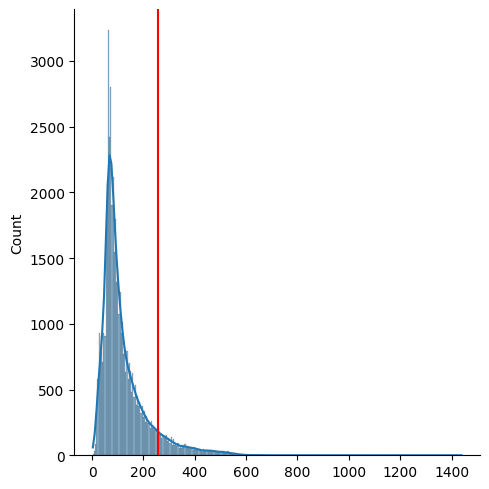

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot([len(l) for l in encoded], kde=True)
# 텍스트 데이터를 처리할 경우 문장단위로 분리하는게 좋음
plt.axvline(x=256, color="red")

In [27]:
max_len = 256
for line in encoded:
    if len(line) < max_len: # 현재 샘플이 정해준 길이보다 짧으면
        line += [word_to_index['<PAD>']] * (max_len - len(line)) # 나머지는 전부 'pad' 토큰으로 채운다.
print('리뷰의 최대 길이 : %d' % max(len(l) for l in encoded))
print('리뷰의 최소 길이 : %d' % min(len(l) for l in encoded))
print('리뷰의 평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))

##########################################################################################
# 전처리 함수 만들기

리뷰의 최대 길이 : 1439
리뷰의 최소 길이 : 256
리뷰의 평균 길이 : 264.642653


In [28]:
# 길이 제한, 위의 데이터 자르기
encoded = [line[:max_len] for line in encoded]
sum(map(len, encoded))/len(encoded)

256.0

In [29]:
y = df["sentiment"].apply(lambda x: 1 if x == 'positive' else 0).values

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded, y,test_size=0.2,stratify=y, shuffle=True)

In [31]:
# 데이터셋 만들기
from torch.utils.data import Dataset
class TextDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float)

    def __getitem__(self, index):
        # x = torch.from_numpy(self.x[index]).float()
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

### AutoTokenizer

※ 참고: 나중에 pretrained model (bert, electra, gpt 등) 사용시에 적용

In [32]:
%pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00


In [33]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [34]:
tokenizer("Using a Transformer network is simple")

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [35]:
tokens = tokenizer.tokenize("Using a Transformer network is simple")
input_ids = tokenizer.convert_tokens_to_ids(tokens)

In [36]:
tokenizer.decode(input_ids)

'Using a Transformer network is simple'

## 4) 모델 정의

In [37]:
class LSTMClassification(nn.Module):
    def __init__(self,
                 num_classes, # 클래스 개수 (긍정 1, 부정 0)
                 embed_size=128, # 단어 임베딩 사이즈
                 vocab_size=8192, # 단어 vocab size
                 sequence_length=256 # 문장 길이 (128)
                 ):
        super(LSTMClassification, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                               embedding_dim=embed_size,
                               padding_idx=1)

        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=128,
                           num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.lstm(x)
        output = self.classifier(hidden[-1])
        return output

model = LSTMClassification(1, )

### Quiz.

만약, 긍정, 부정 2진분류 문제가 아닌 긍정, 부정, 중립 3진분류 문제일 경우
1. 모델의 layer를 어떻게 수정해야 하는지 (Linear Layer)
2. loss 함수는 어떤 것을 사용해야 하는지 (multi class loss)
3. accuracy 계산은 어떻게 해야하는지 (hint: argmax)


In [38]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.BCELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=7, gamma=0.7)

## 5) 모델 학습

In [39]:
# 모델 학습시키기
epochs = 10

history = {
    'loss': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        target = model(data).reshape(-1)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    val_loss = []
    correct = 0
    for data, label in tqdm(iter(test_loader)):
        data, label = data.to(device), label.to(device)
        with torch.no_grad():
            target = model(data).reshape(-1).detach()
        loss = criterion(target, label)
        val_loss.append(loss.item())
        correct += (target>0.5).type(torch.int).eq(label.view_as(target)).sum().item()

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)
    history['val_acc'].append(correct/len(test_loader.dataset))

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Accuracy : [{correct/len(test_loader.dataset):.4f}]')

    scheduler.step()

  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.69439] Val Loss : [0.69414] Val Accuracy : [0.5021]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.69036] Val Loss : [0.69633] Val Accuracy : [0.5036]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.67864] Val Loss : [0.70510] Val Accuracy : [0.5041]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.66681] Val Loss : [0.71665] Val Accuracy : [0.5029]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.66026] Val Loss : [0.72613] Val Accuracy : [0.5037]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.65509] Val Loss : [0.73298] Val Accuracy : [0.5102]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.63053] Val Loss : [0.66683] Val Accuracy : [0.6518]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.56219] Val Loss : [0.61666] Val Accuracy : [0.7041]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.50557] Val Loss : [0.58716] Val Accuracy : [0.7248]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.45372] Val Loss : [0.57942] Val Accuracy : [0.7392]


## 6) 예측 및 평가

In [40]:
# predict on a sample text with positive, negative words

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')


sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')

tokenized=[]

# for sentence in df['review']:
sample_pred_text = re.sub('<br />', ' ', sample_pred_text)
sample_pred_text = re.sub('[^\w\s\'\"\&]+', '', sample_pred_text)
temp = sample_pred_text.lower().split(' ') # 토큰화
temp = [word for word in temp if not word in stopwords] # 불용어 제거
tokenized.append(list(filter(None, temp)))

encoded = []
for line in tokenized: #입력 데이터에서 1줄씩 문장을 읽음
    temp = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
        try:
            temp.append(word_to_index[w]) # 글자를 해당되는 정수로 변환
        except KeyError: # 단어 집합에 없는 단어일 경우 UNK로 대체된다.
            temp.append(word_to_index['<UNK>']) # UNK의 인덱스로 변환
    encoded.append(temp)

max_len = 256
for line in encoded:
    if len(line) < max_len: # 현재 샘플이 정해준 길이보다 짧으면
        line += [word_to_index['<PAD>']] * (max_len - len(line)) # 나머지는 전부 'pad' 토큰으로 채운다.


In [41]:
tokenized

[['movie',
  'good',
  'animation',
  'graphics',
  'terrible',
  'would',
  'recommend',
  'movie']]

In [42]:
encoded

[[2,
  7,
  699,
  2779,
  270,
  9,
  255,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
 

In [43]:
pred_dataset = TextDataset(encoded, [0])
pred_loader = torch.utils.data.DataLoader(pred_dataset, batch_size=1)

In [44]:
# 테스트
model.eval()
val_loss = []
correct = 0
for data, _ in tqdm(iter(pred_loader)):
    data = data.to(device)
    with torch.no_grad():
        target = model(data).reshape(-1).detach()
    prediction = ["positive" if (t>0.5).type(torch.int) else "negative" for t in target]


print(prediction)

  0%|          | 0/1 [00:00<?, ?it/s]

['negative']


In [45]:
# 위의 내용을 함수화
def make_dataloader(sample_text):
    tokenized=[]

    sample_text = re.sub('<br />', ' ', sample_text)
    sample_text = re.sub('[^\w\s\'\"\&]+', '', sample_text)
    temp = sample_text.lower().split(' ') # 토큰화
    temp = [word for word in temp if not word in stopwords] # 불용어 제거
    tokenized.append(list(filter(None, temp)))

    encoded = []
    for line in tokenized: #입력 데이터에서 1줄씩 문장을 읽음
        temp = []
        for w in line: #각 줄에서 1개씩 글자를 읽음
            try:
                temp.append(word_to_index[w]) # 글자를 해당되는 정수로 변환
            except KeyError: # 단어 집합에 없는 단어일 경우 UNK로 대체된다.
                temp.append(word_to_index['<UNK>']) # UNK의 인덱스로 변환
        encoded.append(temp)

    max_len = 256
    for line in encoded:
        if len(line) < max_len: # 현재 샘플이 정해준 길이보다 짧으면
            line += [word_to_index['<PAD>']] * (max_len - len(line)) # 나머지는 전부 'pad' 토큰으로 채운다.

    pred_dataset = TextDataset(encoded, [0])
    pred_loader = torch.utils.data.DataLoader(pred_dataset, batch_size=1)

    return pred_loader


In [46]:
def sample_prediction(sample_text):
    pred_loader = make_dataloader(sample_text)
    # 테스트
    model.eval()
    for data, _ in tqdm(iter(pred_loader)):
        data = data.to(device)
        with torch.no_grad():
            target = model(data).reshape(-1).detach()
        prediction = ["positive" if (t>0.5).type(torch.int) else "negative" for t in target]

    return prediction

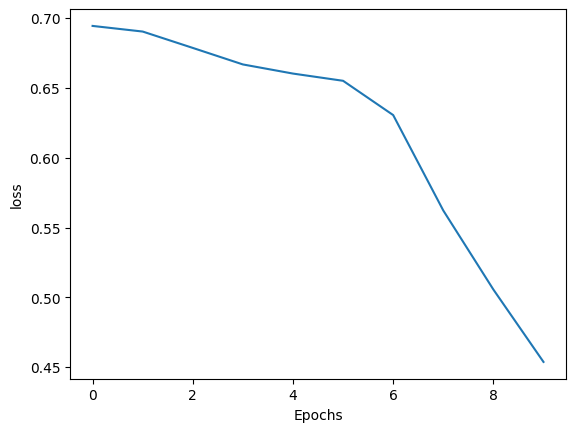

In [47]:
plot_graphs(history, 'loss')

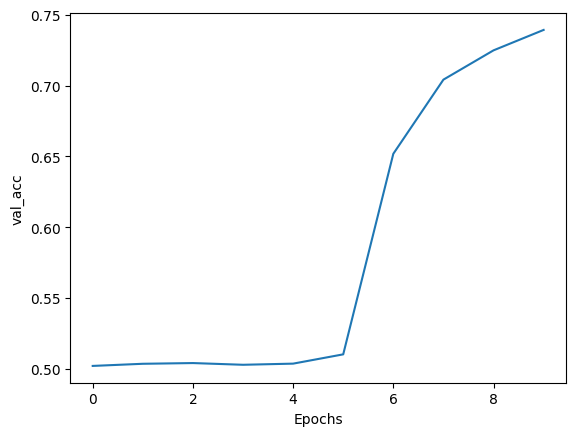

In [48]:
plot_graphs(history, 'val_acc')

---

# 2 GRU

## 1) 모델 정의

In [49]:
class GRUClassification(nn.Module):
    def __init__(self,
                 num_classes, # 클래스 개수 (긍정 1, 부정 0)
                 embed_size=128, # 단어 임베딩 사이즈
                 vocab_size=8192, # 단어 vocab size
                 sequence_length=256 # 문장 길이 (128)
                 ):
        super(GRUClassification, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                               embedding_dim=embed_size,
                               padding_idx=1)

        self.gru = nn.GRU(input_size=embed_size, hidden_size=128,
                           num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.gru(x)
        output = self.classifier(hidden[-1])
        return output

model = GRUClassification(1, )

In [50]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.BCELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=7, gamma=0.7)

## 2) 모델 학습

In [51]:
# 모델 학습시키기
epochs = 10

history = {
    'loss': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        target = model(data).reshape(-1)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    val_loss = []
    correct = 0
    for data, label in tqdm(iter(test_loader)):
        data, label = data.to(device), label.to(device)
        with torch.no_grad():
            target = model(data).reshape(-1).detach()
        loss = criterion(target, label)
        val_loss.append(loss.item())
        correct += (target>0.5).type(torch.int).eq(label.view_as(target)).sum().item()

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)
    history['val_acc'].append(correct/len(test_loader.dataset))

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Accuracy : [{correct/len(test_loader.dataset):.4f}]')

    scheduler.step()

  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.67205] Val Loss : [0.51430] Val Accuracy : [0.7478]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.46323] Val Loss : [0.49072] Val Accuracy : [0.7536]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.65816] Val Loss : [0.74368] Val Accuracy : [0.5125]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.70674] Val Loss : [0.69590] Val Accuracy : [0.5284]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.70522] Val Loss : [0.69777] Val Accuracy : [0.5242]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.70474] Val Loss : [0.69785] Val Accuracy : [0.5340]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.70501] Val Loss : [0.69335] Val Accuracy : [0.5253]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.69882] Val Loss : [0.68993] Val Accuracy : [0.5438]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.69850] Val Loss : [0.68888] Val Accuracy : [0.5425]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.69987] Val Loss : [0.69190] Val Accuracy : [0.5325]


## 3) 예측 및 평가

In [52]:
# predict on a sample text with positive words.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')

predictions = sample_prediction(sample_pred_text)
print(predictions)

  0%|          | 0/1 [00:00<?, ?it/s]

['positive']


In [53]:
# predict on a sample text with negative words

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_prediction(sample_pred_text)
print(predictions)

  0%|          | 0/1 [00:00<?, ?it/s]

['positive']


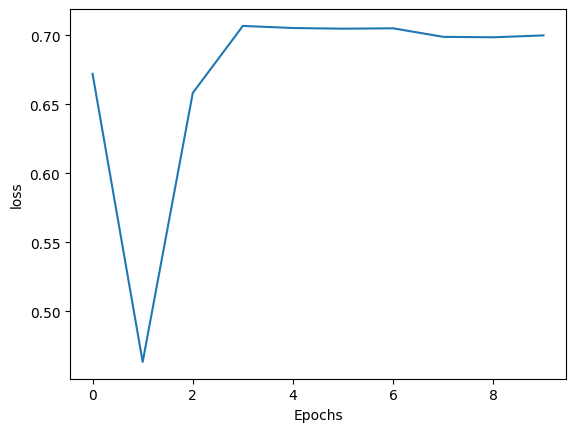

In [54]:
plot_graphs(history, 'loss')

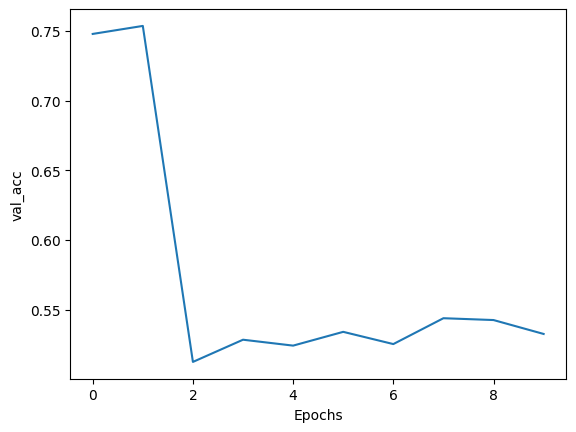

In [55]:
plot_graphs(history, 'val_acc')


---

# 3 LSTM Bidirectional

## 1) 모델 정의

In [56]:
class BLSTMClassification(nn.Module):
    def __init__(self,
                 num_classes, # 클래스 개수 (긍정 1, 부정 0)
                 embed_size=128, # 단어 임베딩 사이즈
                 vocab_size=8192, # 단어 vocab size
                 sequence_length=256 # 문장 길이 (128)
                 ):
        super(BLSTMClassification, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                               embedding_dim=embed_size,
                               padding_idx=1)

        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=128,
                           num_layers=1, bidirectional=True, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128*2, 1), # bidirectional  *2
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, _) = self.lstm(x)
        output = self.classifier(hidden.reshape(x.shape[0], -1))
        return output

model = BLSTMClassification(1, )

In [57]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.BCELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=7, gamma=0.7)

## 2) 모델 학습

In [58]:
# 모델 학습시키기
epochs = 10

history = {
    'loss': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        target = model(data).reshape(-1)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    val_loss = []
    correct = 0
    for data, label in tqdm(iter(test_loader)):
        data, label = data.to(device), label.to(device)
        with torch.no_grad():
            target = model(data).reshape(-1).detach()
        loss = criterion(target, label)
        val_loss.append(loss.item())
        correct += (target>0.5).type(torch.int).eq(label.view_as(target)).sum().item()

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)
    history['val_acc'].append(correct/len(test_loader.dataset))

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Accuracy : [{correct/len(test_loader.dataset):.4f}]')

    scheduler.step()

  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.70177] Val Loss : [0.70037] Val Accuracy : [0.4974]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.70306] Val Loss : [0.69906] Val Accuracy : [0.5014]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.70266] Val Loss : [0.70117] Val Accuracy : [0.5005]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.70309] Val Loss : [0.69841] Val Accuracy : [0.4965]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.70200] Val Loss : [0.70197] Val Accuracy : [0.4924]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.70275] Val Loss : [0.69965] Val Accuracy : [0.4988]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.70270] Val Loss : [0.69753] Val Accuracy : [0.5049]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.70027] Val Loss : [0.69621] Val Accuracy : [0.5049]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.69946] Val Loss : [0.69816] Val Accuracy : [0.5017]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.69990] Val Loss : [0.69733] Val Accuracy : [0.5056]


## 3) 예측 및 평가

In [59]:
# predict on a sample text with positive words.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')

predictions = sample_prediction(sample_pred_text)
print(predictions)

  0%|          | 0/1 [00:00<?, ?it/s]

['positive']


In [60]:
# predict on a sample text with negative words

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_prediction(sample_pred_text)
print(predictions)

  0%|          | 0/1 [00:00<?, ?it/s]

['positive']


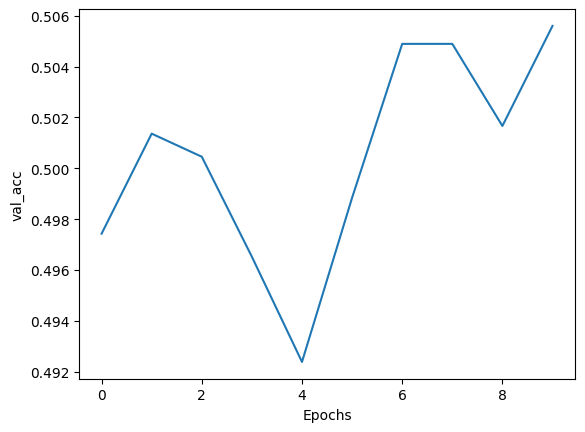

In [61]:
plot_graphs(history, 'val_acc')

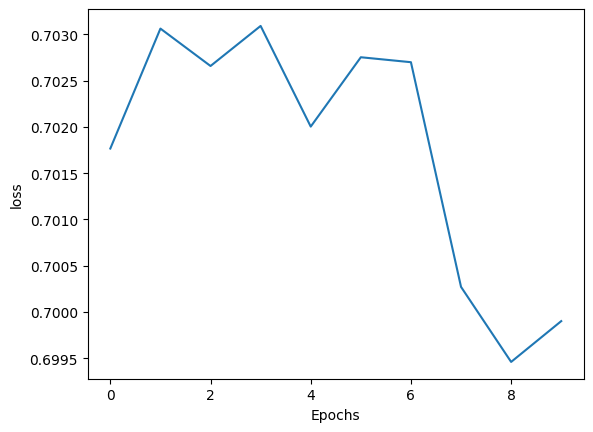

In [62]:
plot_graphs(history, 'loss')

---

# 4 LSTM Stacking

## 1) 모델 정의

In [63]:
class StackLSTMClassification(nn.Module):
    def __init__(self,
                 num_classes, # 클래스 개수 (긍정 1, 부정 0)
                 embed_size=128, # 단어 임베딩 사이즈
                 vocab_size=8192, # 단어 vocab size
                 sequence_length=256 # 문장 길이 (128)
                 ):
        super(StackLSTMClassification, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                               embedding_dim=embed_size,
                               padding_idx=1)

        self.lstm1 = nn.LSTM(input_size=embed_size, hidden_size=128,
                           num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64,
                           num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, _) = self.lstm1(x)
        output, (hidden, _) = self.lstm2(output)
        output = self.classifier(hidden[-1])
        return output

model = StackLSTMClassification(1, )

In [64]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.BCELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=7, gamma=0.7)

## 2) 모델 학습

In [65]:
# 모델 학습시키기
epochs = 10

history = {
    'loss': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        target = model(data).reshape(-1)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    val_loss = []
    correct = 0
    for data, label in tqdm(iter(test_loader)):
        data, label = data.to(device), label.to(device)
        with torch.no_grad():
            target = model(data).reshape(-1).detach()
        loss = criterion(target, label)
        val_loss.append(loss.item())
        correct += (target>0.5).type(torch.int).eq(label.view_as(target)).sum().item()

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)
    history['val_acc'].append(correct/len(test_loader.dataset))

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Accuracy : [{correct/len(test_loader.dataset):.4f}]')

    scheduler.step()

  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.69418] Val Loss : [0.69315] Val Accuracy : [0.5019]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.69383] Val Loss : [0.69522] Val Accuracy : [0.4981]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.66469] Val Loss : [0.51449] Val Accuracy : [0.7611]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.44519] Val Loss : [0.35979] Val Accuracy : [0.8455]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.31975] Val Loss : [0.35024] Val Accuracy : [0.8572]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.26590] Val Loss : [0.32951] Val Accuracy : [0.8555]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.23304] Val Loss : [0.34190] Val Accuracy : [0.8538]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.18899] Val Loss : [0.34154] Val Accuracy : [0.8611]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.16241] Val Loss : [0.33599] Val Accuracy : [0.8642]


  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.14425] Val Loss : [0.37267] Val Accuracy : [0.8644]


## 3) 예측 및 평가

In [66]:
# predict on a sample text with positive words.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_prediction(sample_pred_text)
print(predictions)

  0%|          | 0/1 [00:00<?, ?it/s]

['positive']


In [67]:
# predict on a sample text with negative words.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_prediction(sample_pred_text)
print(predictions)

  0%|          | 0/1 [00:00<?, ?it/s]

['negative']


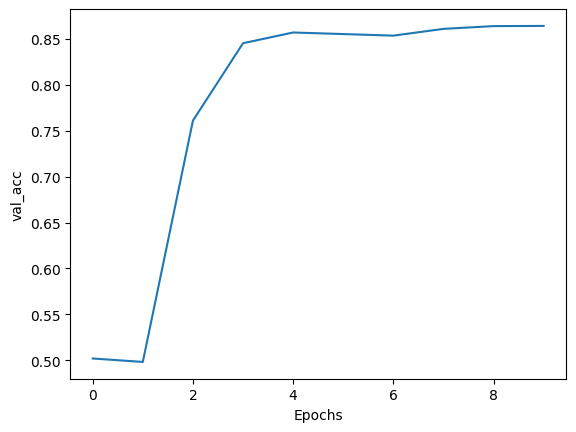

In [68]:
plot_graphs(history, 'val_acc')

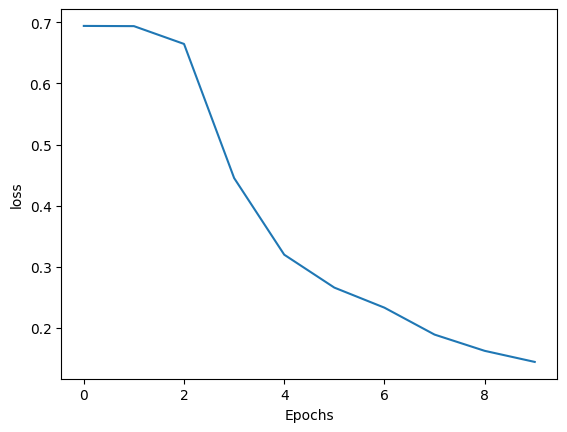

In [69]:
plot_graphs(history, 'loss')